Author: SriSaiCharan Velisetti

In [30]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
from google.colab.patches import cv2_imshow
import time
from mpl_toolkits import mplot3d
import random
from ast import Lt
from scipy.ndimage import gaussian_filter as gf
from google.colab.patches import cv2_imshow
%matplotlib inline

# Affine Structure from Motion 

## Overview
<img src="https://drive.google.com/uc?id=1nYd0eJjBtVIPuapfxuiVzswjswGN_Gq2&export=download" width="800"/>


This problem continues the interest point detection and tracking problem from HW2. Now, you will recover a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png. You are encouraged to use your results from HW2, but in case you were not able to complete it, we have also included pre- computed intermediate results in the supplemental material. Submit your code so that we can reproduce your results.

The outline of the affine structure from motion algorithm:

<img src="https://drive.google.com/uc?id=1BSvHwRR5gNBwDGlrk-dcLCRcuIAvab__&export=download" width="700"/>


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part2_data/tracks.mat')

### Code 

In [71]:
track_x = data['track_x']
track_y = data['track_y']

def affineSFM(x, y):
  '''
  Function: Affine structure from motion algorithm
  % Normalize x, y to zero mean
  % Create measurement matrix
  D = [xn' ; yn'];
  % Decompose and enforce rank 3
  % Apply orthographic constraints

  '''
  #Removing nan values
  track_x = (x[~np.isnan(x).any(axis=1)]).T
  track_y = (y[~np.isnan(x).any(axis=1)]).T

  #Centering Around Mean
  track_x = track_x - np.mean(track_x, axis=1, keepdims=True)
  track_y = track_y - np.mean(track_y, axis=1, keepdims=True)

  # Constructing matrix D 
  D = np.vstack((track_x, track_y))
  U,W,Vt = np.linalg.svd(D)
  U = U[:,:3]
  W = np.diag(W[:3])
  V = Vt[:3,:]
  
  #A-camera poses
  #X-3D points
  A =  np.dot(U,np.sqrt(W))  
  X =  np.dot(np.sqrt(W),V)
  
  y_values = A[51:,:]
  x_values = A[:51,:]

  #Orthographic COnstraints
  affine_eq1 = np.empty((int(A.shape[0]/2), 9))
  affine_eq2 = np.copy(affine_eq1)
  affine_eq3 = np.copy(affine_eq1)
  
  for i in range(int(A.shape[0]/2)):
    affine_eq1[i] = (np.dot(y_values[[i],:].T,x_values[[i],:])).flatten()
    affine_eq2[i] = (np.dot(x_values[[i],:].T,x_values[[i],:])).flatten()   
    affine_eq3[i] = (np.dot(y_values[[i],:].T,y_values[[i],:])).flatten()

  affine_eqs = np.vstack((affine_eq1, affine_eq2, affine_eq3))
  aff = np.hstack((np.asarray([0]*int(A.shape[0]/2)),np.asarray([1]*A.shape[0])))

  L = np.dot(np.linalg.pinv(affine_eqs),aff)  
  C = np.linalg.cholesky((L.reshape(3,3)))
  A = np.dot(A,C)
  X = np.dot(np.linalg.inv(C),X)
 
  return A,X


camera_pos_estimate, points3d_estimate = affineSFM(track_x, track_y)

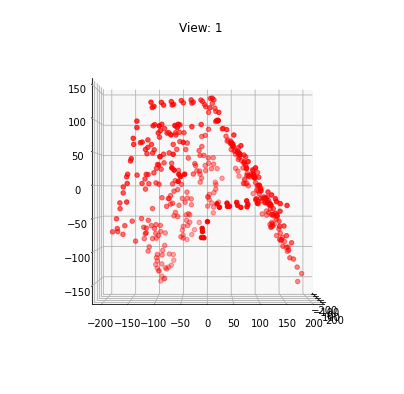

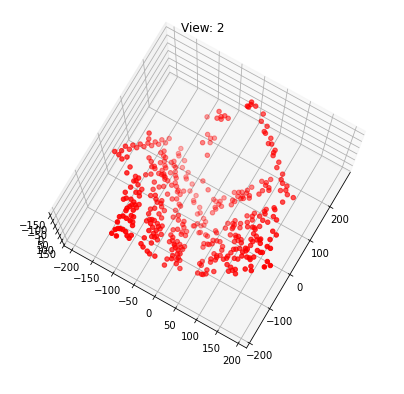

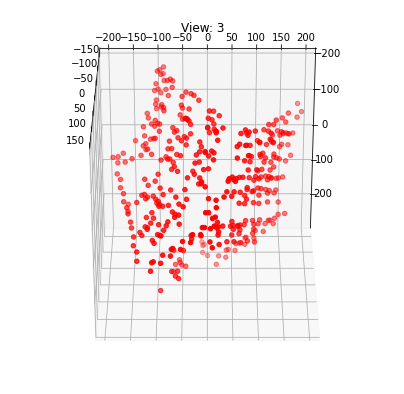

In [110]:
fig = plt.figure()
fig.set_size_inches(7, 7)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points3d_estimate[0, :], points3d_estimate[1, :], points3d_estimate[2, :], color='r', marker='o')
ax.set_title('View: 1 ')
ax.view_init(elev=0, azim=0)
plt.show()

fig = plt.figure()
fig.set_size_inches(7, 7)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points3d_estimate[0, :], points3d_estimate[1, :], points3d_estimate[2, :], color='r', marker='o')
ax.set_title('View: 2')
ax.view_init(elev=-100, azim=-30)
plt.show()

fig = plt.figure()
fig.set_size_inches(7, 7)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points3d_estimate[0, :], points3d_estimate[1, :], points3d_estimate[2, :], color='r', marker='o')
ax.set_title('View: 3')
ax.view_init(elev=-240, azim=0)
plt.show()

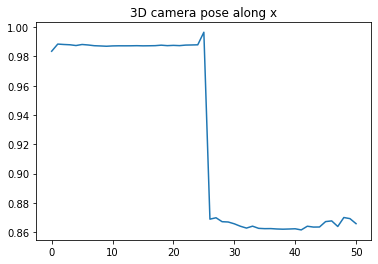

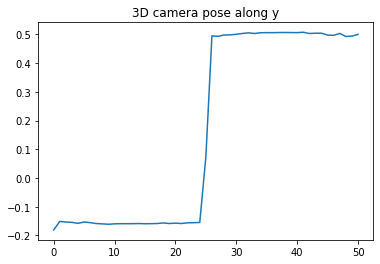

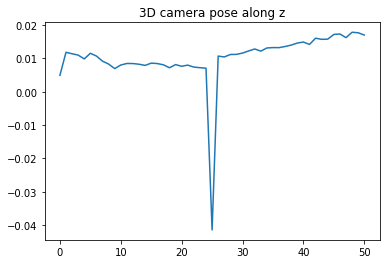

In [73]:
camera_pose = np.zeros((camera_pos_estimate.shape[0] // 2, camera_pos_estimate.shape[1]))

camera_pos_estimate_mean = np.mean(camera_pos_estimate, axis=0)
camera_pos_estimate[:, 0] = camera_pos_estimate[:, 0] / camera_pos_estimate_mean[0]
camera_pos_estimate[:, 1] = camera_pos_estimate[:, 1] / camera_pos_estimate_mean[1]
camera_pos_estimate[:, 2] = camera_pos_estimate[:, 2] / camera_pos_estimate_mean[2]

for i in range(camera_pose.shape[0]):
  a_k = np.cross(camera_pos_estimate[(i *2), :], camera_pos_estimate[(i * 2) + 1, :])
  camera_pose[i, :] = np.divide(a_k, np.linalg.norm(a_k)) 

plt.title('3D camera pose along x')
plt.plot(camera_pose[:, 0])
plt.show()

plt.title('3D camera pose along y')
plt.plot(camera_pose[:, 1])
plt.show()

plt.title('3D camera pose along z')
plt.plot(camera_pose[:, 2])
plt.show()